In [133]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2s
from math import sqrt
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score,KFold,train_test_split,GridSearchCV
from sklearn.model_selection import train_test_split
import os
from scikeras.wrappers import KerasRegressor
import pandas as pd
from keras import regularizers
import yfinance as yf

In [98]:
# Read in csvs and only work with date + adj_close
oil = pd.read_csv('data/CLF_data.csv')
dal = pd.read_csv('data/DAL_data.csv')
oil['Date']=pd.to_datetime(oil['Date'])
oil = oil.set_index('Date')
dal['Date']=pd.to_datetime(dal['Date'])


In [99]:
oil_features = pd.read_feather('oil_features')

In [100]:
oil = oil.join(oil_features).drop(columns=['Date']).iloc[:-48].dropna()


In [111]:
oil = oil.drop(oil.columns[7:48], axis=1)

In [112]:
oil['Open'],oil['Adj Close'] = oil['Adj Close'],oil['Open'] 
oil = oil.rename({'Open':'temp'},axis=1)
oil = oil.rename({'Adj Close':'Open'},axis=1)
oil = oil.rename({'temp':'Adj Close'},axis=1)


In [113]:
# Produces n-grams n is the number of days of stock data each input will have, this is the memory of the RNN or the width
N = 14

oil_X = np.array([oil.iloc[i-N:i] for i in range(N,len(oil))])
oil_Y = np.array([oil.iloc[i] for i in range(N,len(oil))])
oil_Y = oil_Y[:,0]


print(oil_X.shape,oil_Y.shape)

(2412, 14, 16) (2412,)


In [114]:
X_train, X_test, Y_train, Y_test = train_test_split(oil_X, oil_Y, test_size=0.1, shuffle=False)

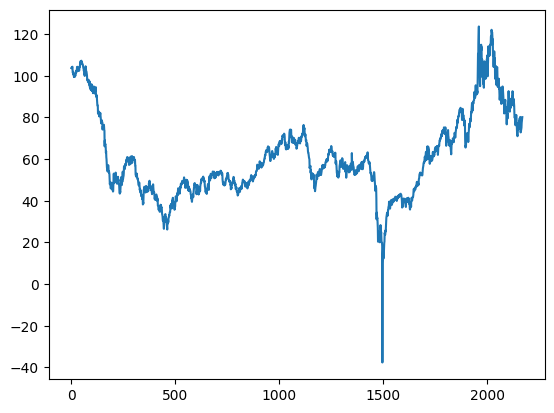

In [166]:
plt.plot(Y_train)

In [116]:
# Scales input data by mean and variance of TRAINING samples, use inverse_transform to compare predictions to targets
scaler=StandardScaler()
scaler=scaler.fit(X_train.reshape(-1,1))
oil_scaled = scaler.transform(X_train.reshape(-1,1)).reshape(X_train.shape)
oil_test_scaled = scaler.transform(X_test.reshape(-1,1)).reshape(X_test.shape)

In [169]:
def create_model():
    model=Sequential()
    model.add(keras.Input(shape=(X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(150, activation='relu', return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(50,activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4)))
    model.add(LSTM(50, activation= 'relu',return_sequences=False,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(optimizer='adam',loss='mse')
    
    clf = KerasRegressor(
        model,
        loss="negative_mean_squared_error",
        hidden_layer_sizes=(300,150,50),
    )
    return model

In [170]:
model = create_model()
model.summary()
history=model.fit(X_train,Y_train,epochs=40,batch_size=32, validation_split=0.1,verbose=1)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 14, 150)        │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 14, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 14, 50)         │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,001 (500.00 KB)

 Trainable params: 128,001 (500.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1777489792.0000 - val_loss: 5800286.5000
Epoch 2/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 248714144.0000 - val_loss: 6434418.5000
Epoch 3/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 190128656.0000 - val_loss: 2273422.7500
Epoch 4/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 96421520.0000 - val_loss: 5337469.0000
Epoch 5/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 43457020.0000 - val_loss: 199469.1719
Epoch 6/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 10899906.0000 - val_loss: 15877.3574
Epoch 7/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5102555.5000 - val_loss: 38438.0273
Epoch 8/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2059174.6250 - val_loss: 14982.6465
Epoch 9/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1584818.2500 - val_loss: 58832.1211
Epoch 10/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7186094.0000 - val_loss: 15067.0605
Epoch 11/40
62/62 ━━━━━━━━━━━━

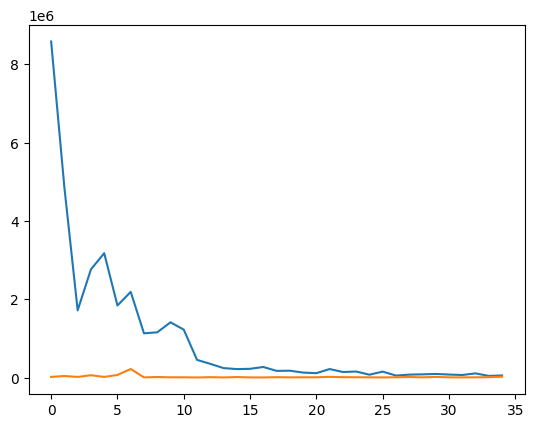

In [176]:
plt.plot(history.history['loss'][5:])
plt.plot(np.array(history.history['val_loss'][5:]) )
plt.show()

In [177]:
prediction = model.predict(X_test)
prediction

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


array([[-48.122524 ],
       [-43.82989  ],
       [-50.49402  ],
       [-51.281136 ],
       [-53.34637  ],
       [-51.54078  ],
       [-52.64961  ],
       [-52.167305 ],
       [-30.47358  ],
       [-26.722645 ],
       [-24.80816  ],
       [-33.739265 ],
       [-33.77789  ],
       [-35.737003 ],
       [-39.03092  ],
       [-47.6337   ],
       [-46.314945 ],
       [-47.843376 ],
       [-48.59773  ],
       [-49.13485  ],
       [-55.50127  ],
       [-60.162773 ],
       [-59.676907 ],
       [-63.41524  ],
       [-41.1319   ],
       [-55.861645 ],
       [-54.498222 ],
       [-56.146427 ],
       [-36.61093  ],
       [-44.90731  ],
       [-28.9212   ],
       [-34.25565  ],
       [-43.390667 ],
       [-40.953133 ],
       [-34.137383 ],
       [-38.528954 ],
       [-37.143906 ],
       [-44.978664 ],
       [-30.586754 ],
       [-44.17317  ],
       [-44.23684  ],
       [-62.397484 ],
       [-50.044453 ],
       [-61.185516 ],
       [-65.32852  ],
       [-6

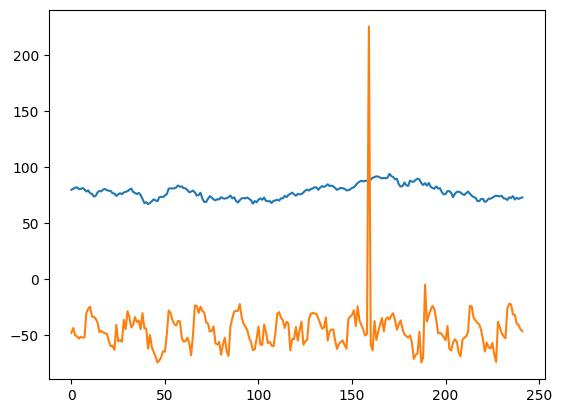

In [173]:
plt.plot(Y_test)
plt.plot(prediction[:,0])
plt.show()

In [178]:
print("---------")
print(f"MAE:{mae(Y_test,prediction[:,0])}")
print("---------")
print(f"MSE: {mse(Y_test,prediction[:,0])}") 

---------
MAE:123.81058679336358
---------
MSE: 15512.956137099265


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


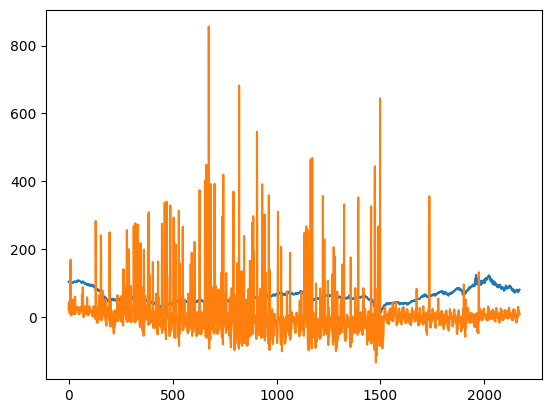

In [179]:
prediction = model.predict(X_train)
plt.plot(Y_train)
plt.plot(prediction[:,0] + 50)
plt.show()